In [0]:
# You only need to run this if you are using the docker environment.
# In the databricks environment a Spark Contect will already have been created
import os

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType

from pyspark.sql.types import IntegerType
from pyspark.sql import Row
from pyspark.sql import SparkSession

SPARK_MASTER=os.getenv('SPARK_MASTER')
SPARK_APP_NAME='dataframes'


conf = SparkConf().setMaster(SPARK_MASTER) \
                  .setAppName(SPARK_APP_NAME)
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.master(SPARK_MASTER).appName(SPARK_APP_NAME).getOrCreate()

In [0]:
path = "/FileStore/tables/atussum.csv"

In [0]:
from pyspark.sql.types import DoubleType

dataFrame = spark.read.format("csv").options(header=True, inferSchema=True, delimiter=",").load(path)

structType = []

for colum_name in dataFrame.columns:
    if colum_name == dataFrame.columns[0]:
        structType.append(StructField(colum_name,StringType(),True))
    else:
        structType.append(StructField(colum_name,DoubleType(),True))
        
schema = StructType(structType)

dataFrame = spark.read.format("csv").options(header=True, inferSchema=False, delimiter=",").schema(schema).load(path)

In [0]:
## primary needs activities (sleeping, eating, etc.)
primary_activities_columns = [column for column in dataFrame.columns \
                    if column.startswith("t01") \
                    or column.startswith("t03") \
                    or column.startswith("t11") \
                    or column.startswith("t1801") \
                    or column.startswith("t1803")]
primary_activities_dataFrame = dataFrame.select(primary_activities_columns)

In [0]:
## working activities
working_activities_columns = [column for column in dataFrame.columns \
                    if column.startswith("t05") \
                    or column.startswith("t1805")]
working_activities_dataFrame = dataFrame.select(working_activities_columns)

In [0]:
## other activities (leisure)
other_activities_columns = [column for column in dataFrame.columns \
                    if column.startswith("t02") \
                    or column.startswith("t04") \
                    or column.startswith("t06") \
                    or column.startswith("t07") \
                    or column.startswith("t08") \
                    or column.startswith("t09") \
                    or column.startswith("t10") \
                    or column.startswith("t12") \
                    or column.startswith("t13") \
                    or column.startswith("t14") \
                    or column.startswith("t15") \
                    or column.startswith("t16") \
                    or column.startswith("t18")]

other_activities_columns = [column for column in other_activities_columns if column not in primary_activities_columns]
other_activities_columns = [column for column in other_activities_columns if column not in working_activities_columns]

other_activities_dataFrame = dataFrame.select(other_activities_columns)

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.functions import when
#labour force column “telfs” (values 1 and 2 indicate employed people)
#sex column “tesex”, value 1 is a male respondent, 2 a female respondent
composed_dataFrame = dataFrame \
    .withColumn('primary_activities_in_h', sum(primary_activities_dataFrame[col] for col in primary_activities_dataFrame.columns)) \
    .withColumn('working_activities_in_h', sum(working_activities_dataFrame[col] for col in working_activities_dataFrame.columns)) \
    .withColumn('other_activities_in_h', sum(other_activities_dataFrame[col] for col in other_activities_dataFrame.columns)) \
    .withColumn('age_as_a_group', when(dataFrame.teage < 22, 'young').when((dataFrame.teage >= 22) & (dataFrame.teage <= 55), 'active').when(dataFrame.teage > 55, 'elderly').otherwise('other'))\
    .withColumn('sex', when(dataFrame.tesex == 1, 'male').when(dataFrame.tesex == 2, 'female').otherwise('other'))\
    .withColumn('labour_force', when(dataFrame.telfs <= 2, 'employed').otherwise('other'))\
    .select(['tucaseid', 'labour_force', 'sex', 'age_as_a_group', 'primary_activities_in_h', 'working_activities_in_h', 'other_activities_in_h'])

In [0]:
composed_dataFrame.printSchema()

root
 |-- tucaseid: string (nullable = true)
 |-- labour_force: string (nullable = false)
 |-- sex: string (nullable = false)
 |-- age_as_a_group: string (nullable = false)
 |-- primary_activities_in_h: double (nullable = true)
 |-- working_activities_in_h: double (nullable = true)
 |-- other_activities_in_h: double (nullable = true)



In [0]:
composed_dataFrame.display()

tucaseid labour_force sex age_as_a_group primary_activities_in_h working_activities_in_h other_activities_in_h 20030100013280 employed male elderly 915.0 0.0 525.0 20030100013344 employed female active 830.0 0.0 610.0 20030100013352 employed female active 715.0 0.0 725.0 20030100013848 other female active 785.0 120.0 535.0 20030100014165 employed male active 707.0 515.0 218.0 20030100014169 employed female active 1020.0 0.0 420.0 20030100014209 employed female active 767.0 514.0 159.0 20030100014427 employed female young 540.0 545.0 355.0 20030100014550 employed female active 790.0 0.0 650.0 20030100014758 employed female active 401.0 270.0 769.0 20030100014928 employed male active 590.0 728.0 122.0 20030100015106 employed female active 745.0 0.0 695.0 20030100015322 employed female active 698.0 380.0 362.0 20030100015390 other male young 840.0 0.0 600.0 20030100015490 employed female active 729.0 540.0 171.0 20030100015890 employed female active 825.0 45.0 570.0 20030100015891 other female elderly 675.0 0.0 765.0 20030100015941 employed female active 670.0 65.0 705.0 20030100015986 other female active 760.0 0.0 680.0 20030100016070 employed female young 685.0 0.0 755.0 20030101030010 other male active 600.0 0.0 840.0 20030101030056 employed female active 948.0 0.0 492.0 20030101030074 employed male active 580.0 697.0 163.0 20030101030082 other male young 845.0 0.0 445.0 20030101030093 employed female active 726.0 478.0 236.0 20030101030124 other female young 813.0 0.0 627.0 20030101030132 other female active 673.0 0.0 767.0 20030101030152 other male elderly 1020.0 0.0 420.0 20030101030154 other female elderly 810.0 0.0 630.0 20030101030157 employed male active 590.0 585.0 265.0 20030101030168 employed male young 860.0 0.0 580.0 20030101030173 employed female active 695.0 440.0 305.0 20030101030501 employed male active 1020.0 165.0 255.0 20030101030549 other female elderly 925.0 0.0 515.0 20030101030553 employed female elderly 805.0 0.0 529.0 20030101030598 other female elderly 735.0 0.0 705.0 20030101030600 employed male active 560.0 595.0 285.0 20030101030611 employed female active 525.0 275.0 640.0 20030101030638 employed male active 551.0 545.0 314.0 20030101030642 employed male active 495.0 180.0 765.0 20030101030658 other male active 630.0 0.0 810.0 20030101030673 employed male active 563.0 520.0 338.0 20030101030758 employed male active 650.0 0.0 790.0 20030101030796 employed female elderly 1100.0 0.0 340.0 20030101030811 employed male active 950.0 0.0 490.0 20030101030813 other female young 570.0 0.0 870.0 20030101030828 employed male active 665.0 0.0 775.0 20030101030830 other female young 893.0 0.0 547.0 20030101030843 other female elderly 626.0 0.0 814.0 20030101030862 employed male active 780.0 0.0 660.0 20030101030883 other female active 635.0 0.0 805.0 20030101030914 employed female active 730.0 0.0 710.0 20030101030930 employed male active 673.0 0.0 767.0 20030101030947 employed male active 695.0 505.0 190.0 20030101030962 other male young 645.0 0.0 795.0 20030101031007 other male elderly 667.0 0.0 773.0 20030101031020 employed male active 762.0 0.0 678.0 20030101031030 employed female elderly 481.0 0.0 959.0 20030101031035 employed female active 625.0 650.0 165.0 20030101031036 other female active 965.0 0.0 475.0 20030101031047 employed female active 575.0 515.0 350.0 20030101031049 other female elderly 750.0 0.0 690.0 20030101031055 employed female elderly 888.0 0.0 552.0 20030101031073 employed male active 445.0 935.0 60.0 20030101031074 employed male active 400.0 790.0 250.0 20030101031095 employed male active 515.0 670.0 255.0 20030101031117 employed female active 645.0 0.0 775.0 20030101031150 other female elderly 540.0 0.0 900.0 20030101031157 employed female active 890.0 0.0 550.0 20030101031171 employed female active 690.0 205.0 405.0 20030101031183 other female elderly 780.0 0.0 660.0 20030101031197 other female active 667.0 0.0 763.0 20030101031225 other female elderly 782.0 0.0 658.0 20030101031231 o

##Q1: how much time do the respondents spend on primary needs compared to other activities?

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

avg_activities_dataFrame = composed_dataFrame.agg({'primary_activities_in_h': 'avg', 'working_activities_in_h': 'avg', 'other_activities_in_h': 'avg'})

avg_activities_dataFrame.display()

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 681.4101918731927 172.72923519977522 573.8451844394235

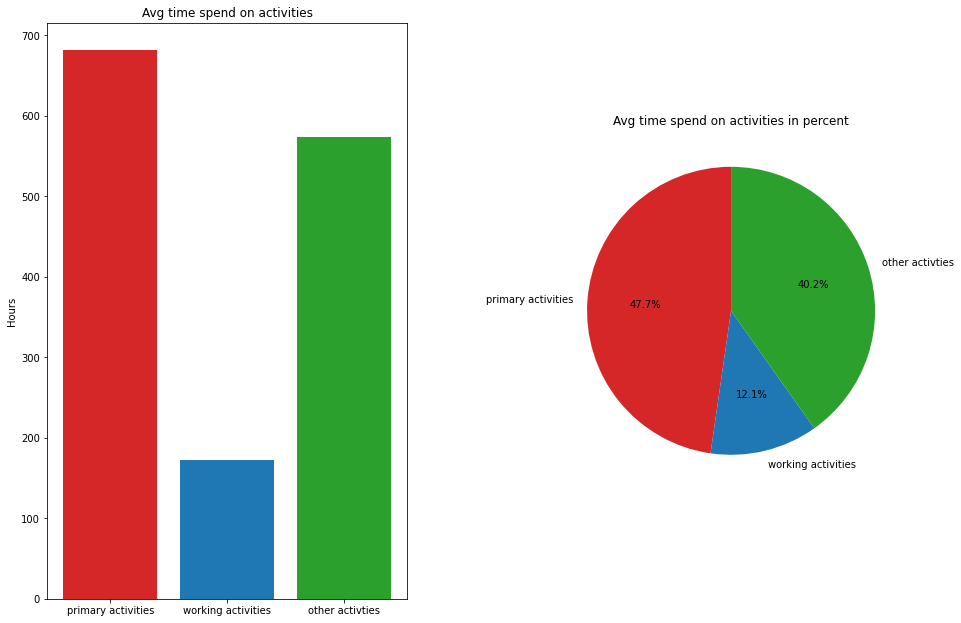

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
labels = ['primary activities', 'working activities', 'other activties']
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax1.bar(labels, avg_activities_dataFrame.collect()[0], color=bar_colors)
ax1.set_ylabel('Hours')
ax1.set_title('Avg time spend on activities')

ax2.pie(avg_activities_dataFrame.collect()[0], labels=labels, autopct='%1.1f%%', startangle=90, colors=bar_colors)
ax2.set_title('Avg time spend on activities in percent')

plt.show()

##A1: The average time for primary time is: 681 hours which is 47,7%

##Q2: Do women and men spend the same amount of time in working?

In [0]:
female_male_dataFrame = composed_dataFrame.groupBy("sex") \
                                        .agg({'working_activities_in_h': 'avg'})
female_male_dataFrame.display()

sex avg(working_activities_in_h) female 140.4197868468937 male 214.3454939933304

In [0]:
female_male_working_plot = [female_male_dataFrame.filter(col("sex") == "female").first()['avg(working_activities_in_h)'],
                          female_male_dataFrame.filter(col("sex") == "male").first()['avg(working_activities_in_h)']]

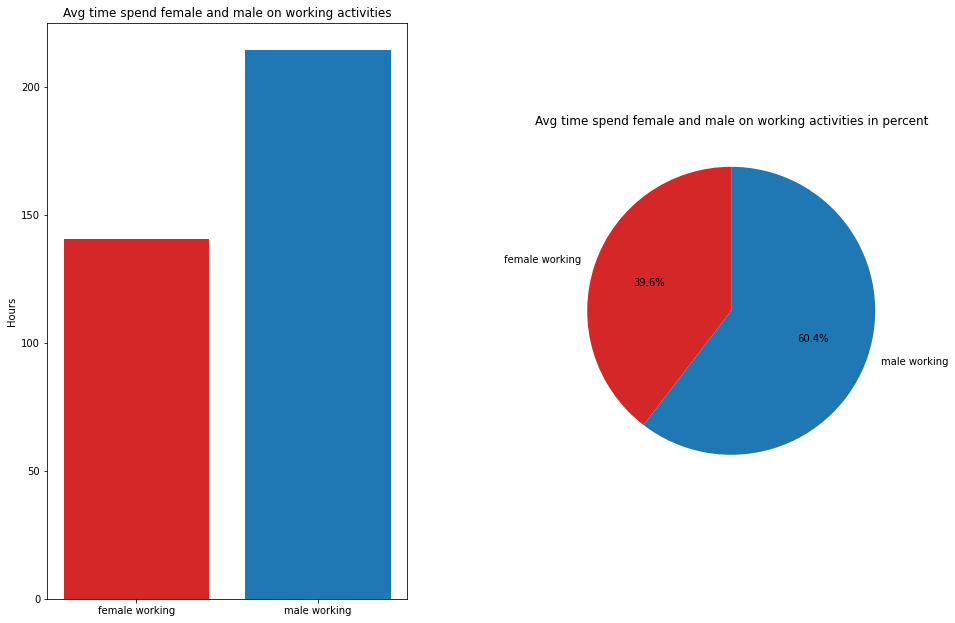

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
labels = ['female working', 'male working']
bar_colors = ['tab:red', 'tab:blue']

ax1.bar(labels, female_male_working_plot, color=bar_colors)
ax1.set_ylabel('Hours')
ax1.set_title('Avg time spend female and male on working activities')

ax2.pie(female_male_working_plot, labels=labels, autopct='%1.1f%%', startangle=90, colors=bar_colors)
ax2.set_title('Avg time spend female and male on working activities in percent')

plt.show()

##A2: No, women spend an average of 140.41 hours at work and men 214.23 hours. This is 39.6% to 60.4%.

##Q3: Does the time spent on primary needs change when people get older?

In [0]:
avg_primary_time_spent_per_age_group = composed_dataFrame.groupBy("age_as_a_group") \
                                                    .agg({'primary_activities_in_h': 'avg'})

avg_primary_time_spent_per_age_group.display()

age_as_a_group avg(primary_activities_in_h) elderly 662.2209470731663 active 689.3074325310703 young 698.7807147076196

In [0]:
time_spent_per_age_group_plot = [avg_primary_time_spent_per_age_group.filter(col("age_as_a_group") == "young").first()['avg(primary_activities_in_h)'],
                                avg_primary_time_spent_per_age_group.filter(col("age_as_a_group") == "active").first()['avg(primary_activities_in_h)'],
                                avg_primary_time_spent_per_age_group.filter(col("age_as_a_group") == "elderly").first()['avg(primary_activities_in_h)']]

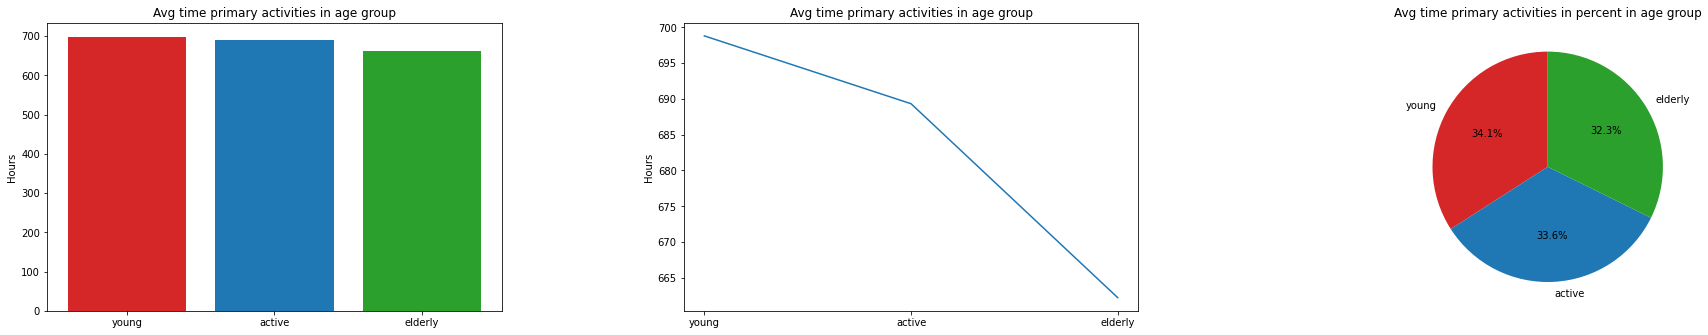

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
labels = ['young', 'active', 'elderly']
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax1.bar(labels, time_spent_per_age_group_plot, color=bar_colors)
ax1.set_ylabel('Hours')
ax1.set_title('Avg time primary activities in age group')

ax2.plot(labels, time_spent_per_age_group_plot)
ax2.set_ylabel('Hours')
ax2.set_title('Avg time primary activities in age group')

ax3.pie(time_spent_per_age_group_plot, labels=labels, autopct='%1.1f%%', startangle=90, colors=bar_colors)
ax3.set_title('Avg time primary activities in percent in age group')

plt.show()

##A3: Yes, as we age, there is less time for primary needs

##Q4: How much time do employed people spend on leisure compared to unemployed people?

In [0]:
avg_other_time_labour_force = composed_dataFrame.groupBy("labour_force") \
                                                    .agg({'other_activities_in_h': 'avg'})
avg_other_time_labour_force.display()

labour_force avg(other_activities_in_h) other 708.4596854562442 employed 492.76488904728853

In [0]:
other_time_spent_per_labour_force_plot = [avg_other_time_labour_force.filter(col("labour_force") == "employed").first()['avg(other_activities_in_h)'],
                                avg_other_time_labour_force.filter(col("labour_force") == "other").first()['avg(other_activities_in_h)']]

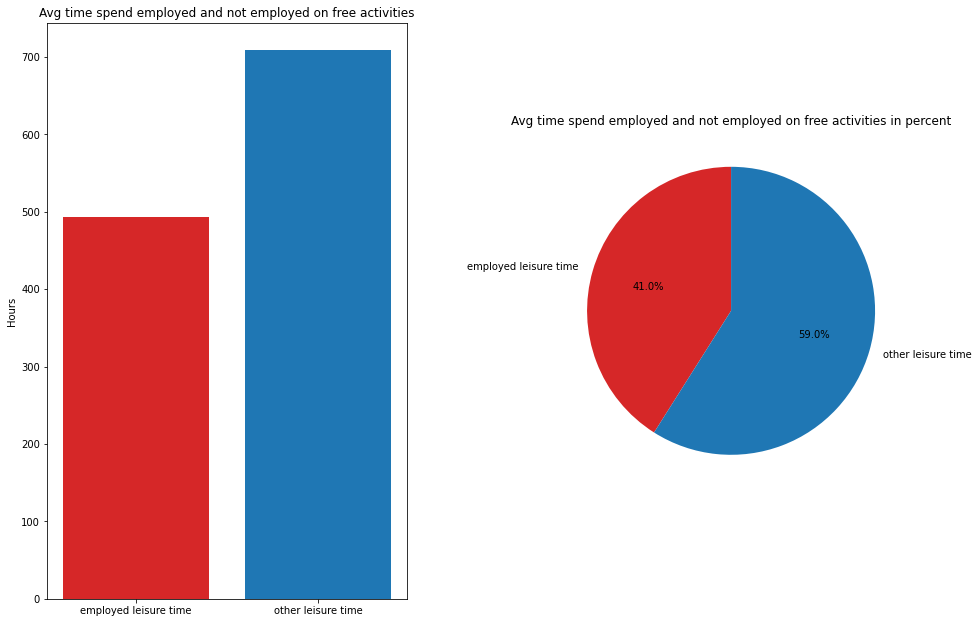

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
labels = ['employed leisure time', 'other leisure time']
bar_colors = ['tab:red', 'tab:blue']

ax1.bar(labels, other_time_spent_per_labour_force_plot, color=bar_colors)
ax1.set_ylabel('Hours')
ax1.set_title('Avg time spend employed and not employed on free activities')

ax2.pie(other_time_spent_per_labour_force_plot, labels=labels, autopct='%1.1f%%', startangle=90, colors=bar_colors)
ax2.set_title('Avg time spend employed and not employed on free activities in percent')

plt.show()

##A4: The workers spend less time on leisure activities to non-workers

## Following are all combinations visualized

In [0]:
activities_by_labour_sex_age = composed_dataFrame.groupBy(["labour_force", "sex", "age_as_a_group"]) \
                                        .agg({'primary_activities_in_h': 'avg', 'working_activities_in_h': 'avg', 'other_activities_in_h': 'avg'})

activities_by_labour_sex_age.display()

labour_force sex age_as_a_group avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) employed female young 695.7021642047406 189.28512538646513 543.9608381999313 employed male elderly 624.5701401716832 286.18385309138324 518.914375747039 other female young 732.8250325945241 6.848239895697523 687.1306388526727 employed female elderly 637.0343147006166 234.71881838074398 556.712651680923 employed male young 655.1890117484451 211.84934346924672 563.1513476157568 other male active 700.4164592961251 26.203163881976536 698.166014930679 other male young 699.9477459016393 7.644211065573771 719.545850409836 other female elderly 684.8766803039158 2.340916243312503 736.3655532077507 other female active 776.3267587536138 9.276839061998073 639.0960488274976 other male elderly 669.5632712500958 4.290411588871005 751.0260596305665 employed male active 650.401370239792 313.1661540769635 466.9171354987123 employed female active 692.6517910842736 249.50742175283278 487.8911877210287

In [0]:
employed_male_young = activities_by_labour_sex_age.filter(col("labour_force") == "employed") \
                                                    .filter(col("sex") == "male") \
                                                    .filter(col("age_as_a_group") == "young") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

other_male_young = activities_by_labour_sex_age.filter(col("labour_force") == "other") \
                                                    .filter(col("sex") == "male") \
                                                    .filter(col("age_as_a_group") == "young") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

employed_female_young = activities_by_labour_sex_age.filter(col("labour_force") == "employed") \
                                                    .filter(col("sex") == "female") \
                                                    .filter(col("age_as_a_group") == "young") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

other_female_young = activities_by_labour_sex_age.filter(col("labour_force") == "other") \
                                                    .filter(col("sex") == "female") \
                                                    .filter(col("age_as_a_group") == "young") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

employed_male_young.display()
other_male_young.display()
employed_female_young.display()
other_female_young.display()

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 655.1890117484451 211.84934346924672 563.1513476157568

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 699.9477459016393 7.644211065573771 719.545850409836

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 695.7021642047406 189.28512538646513 543.9608381999313

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 732.8250325945241 6.848239895697523 687.1306388526727

In [0]:
employed_male_active = activities_by_labour_sex_age.filter(col("labour_force") == "employed") \
                                                    .filter(col("sex") == "male") \
                                                    .filter(col("age_as_a_group") == "active") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

other_male_active = activities_by_labour_sex_age.filter(col("labour_force") == "other") \
                                                    .filter(col("sex") == "male") \
                                                    .filter(col("age_as_a_group") == "active") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

employed_female_active = activities_by_labour_sex_age.filter(col("labour_force") == "employed") \
                                                    .filter(col("sex") == "female") \
                                                    .filter(col("age_as_a_group") == "active") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

other_female_active = activities_by_labour_sex_age.filter(col("labour_force") == "other") \
                                                    .filter(col("sex") == "female") \
                                                    .filter(col("age_as_a_group") == "active") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

employed_male_active.display()
other_male_active.display()
employed_female_active.display()
other_female_active.display()

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 650.401370239792 313.1661540769635 466.9171354987123

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 700.4164592961251 26.203163881976536 698.166014930679

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 692.6517910842736 249.50742175283278 487.8911877210287

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 776.3267587536138 9.276839061998073 639.0960488274976

In [0]:
employed_male_elderly = activities_by_labour_sex_age.filter(col("labour_force") == "employed") \
                                                    .filter(col("sex") == "male") \
                                                    .filter(col("age_as_a_group") == "elderly") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

other_male_elderly = activities_by_labour_sex_age.filter(col("labour_force") == "other") \
                                                    .filter(col("sex") == "male") \
                                                    .filter(col("age_as_a_group") == "elderly") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

employed_female_elderly = activities_by_labour_sex_age.filter(col("labour_force") == "employed") \
                                                    .filter(col("sex") == "female") \
                                                    .filter(col("age_as_a_group") == "elderly") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

other_female_elderly = activities_by_labour_sex_age.filter(col("labour_force") == "other") \
                                                    .filter(col("sex") == "female") \
                                                    .filter(col("age_as_a_group") == "elderly") \
                                                    .select(["avg(primary_activities_in_h)","avg(working_activities_in_h)","avg(other_activities_in_h)"])

employed_male_elderly.display()
other_male_elderly.display()
employed_female_elderly.display()
other_female_elderly.display()

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 624.5701401716832 286.18385309138324 518.914375747039

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 669.5632712500958 4.290411588871005 751.0260596305665

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 637.0343147006166 234.71881838074398 556.712651680923

avg(primary_activities_in_h) avg(working_activities_in_h) avg(other_activities_in_h) 684.8766803039158 2.340916243312503 736.3655532077507

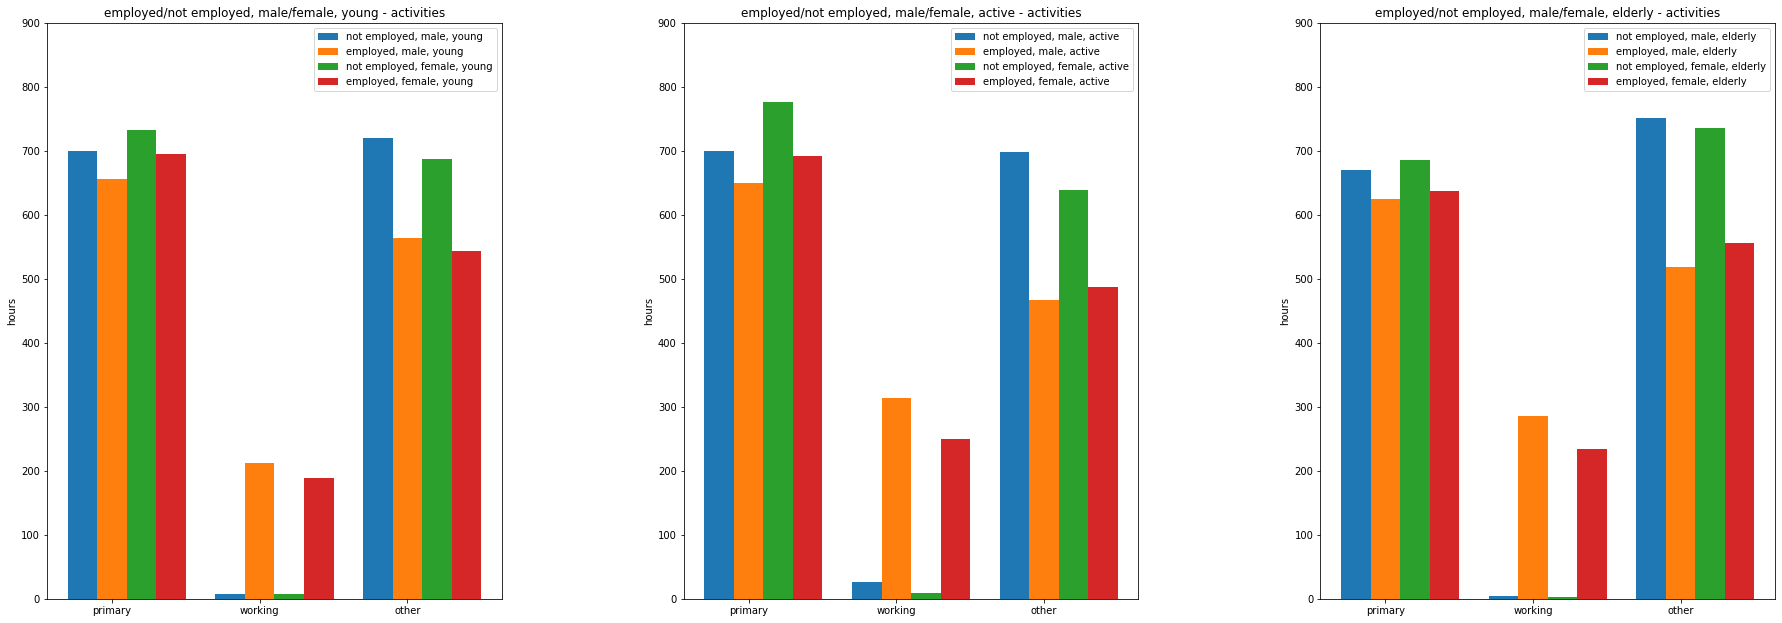

In [0]:
import numpy as np
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
labels = ['primary', 'working', 'other']
barWidth = 0.20

bar1 = np.arange(len(labels))
bar2 = [x + barWidth for x in bar1]
bar3 = [x + barWidth for x in bar2]
bar4 = [x + barWidth for x in bar3]

### Employed/not Employed - Male/Female - young
ax1.bar(bar1, other_male_young.collect()[0], barWidth, label='not employed, male, young')
ax1.bar(bar2, employed_male_young.collect()[0], barWidth, label='employed, male, young')
ax1.bar(bar3, other_female_young.collect()[0], barWidth, label='not employed, female, young')
ax1.bar(bar4, employed_female_young.collect()[0], barWidth, label='employed, female, young')

ax1.set_ylabel('hours')
ax1.set_title('employed/not employed, male/female, young - activities')
ax1.set_xticks(bar2)
ax1.set_xticklabels(labels, fontdict=None, minor=False)
ax1.axis(ymin=0,ymax=900)
ax1.legend()

### Employed/not Employed - Male/Female - active
ax2.bar(bar1, other_male_active.collect()[0], barWidth, label='not employed, male, active')
ax2.bar(bar2, employed_male_active.collect()[0], barWidth, label='employed, male, active')
ax2.bar(bar3, other_female_active.collect()[0], barWidth, label='not employed, female, active')
ax2.bar(bar4, employed_female_active.collect()[0], barWidth, label='employed, female, active')

ax2.set_ylabel('hours')
ax2.set_title('employed/not employed, male/female, active - activities')
ax2.set_xticks(bar2)
ax2.set_xticklabels(labels, fontdict=None, minor=False)
ax2.axis(ymin=0,ymax=900)
ax2.legend()

### Employed/not Employed - Male/Female - elderly
ax3.bar(bar1, other_male_elderly.collect()[0], barWidth, label='not employed, male, elderly')
ax3.bar(bar2, employed_male_elderly.collect()[0], barWidth, label='employed, male, elderly')
ax3.bar(bar3, other_female_elderly.collect()[0], barWidth, label='not employed, female, elderly')
ax3.bar(bar4, employed_female_elderly.collect()[0], barWidth, label='employed, female, elderly')

ax3.set_ylabel('hours')
ax3.set_title('employed/not employed, male/female, elderly - activities')
ax3.set_xticks(bar2)
ax3.set_xticklabels(labels, fontdict=None, minor=False)
ax3.axis(ymin=0,ymax=900)
ax3.legend()

plt.show()